In [1]:
import os
os.environ['THEANO_FLAGS']='floatX=float32,device=cuda,optimizer=fast_run,dnn.library_path=/usr/lib'
channel_first = True
channel_axis=1

In [2]:
import numpy as np
import theano
import theano.tensor as T
import lasagne
from lasagne.layers import DropoutLayer, ReshapeLayer, InputLayer 
floatX = theano.config.floatX
from lasagne.layers import Conv2DLayer, TransposedConv2DLayer, ConcatLayer, NonlinearityLayer
from lasagne.layers import batch_norm
from lasagne.nonlinearities import LeakyRectify, sigmoid, rectify, tanh

Using cuDNN version 7002 on context None
Mapped name None to device cuda: GeForce GTX 1080 (0000:01:00.0)


In [3]:
conv_init = lasagne.init.Normal(0.02, 0)
gamma_init = lasagne.init.Normal(0.02, 1)

In [4]:
def BASIC_D(nc_in, nc_out, ndf, max_layers=3):
    input_a = InputLayer(shape=(None, nc_in, 256, 256))
    input_b = InputLayer(shape=(None, nc_out, 256, 256))
    _ = ConcatLayer([input_a, input_b])
    _ = Conv2DLayer(_, num_filters=ndf, filter_size=4, stride=2, pad=1, W=conv_init, flip_filters=False,                
                nonlinearity=LeakyRectify(0.2))
    use_batchnorm = True
    for layer in range(1, max_layers):        
        out_feat = ndf * min(2**layer, 8)
        _ = Conv2DLayer(_, num_filters=out_feat, filter_size=4, stride=2, pad=1, W=conv_init, flip_filters=False,
                nonlinearity=LeakyRectify(0.2))
        if use_batchnorm:
            _ = batch_norm(_, epsilon=1e-5, gamma=gamma_init)
    
    out_feat = ndf*min(2**max_layers, 8)
    _ = Conv2DLayer(_, num_filters=out_feat, filter_size=4, stride=1, pad=1, W=conv_init, flip_filters=False,
                nonlinearity=LeakyRectify(0.2))
    if use_batchnorm:
        _ = batch_norm(_, epsilon=1e-5, gamma=gamma_init)       
    
    # final layer
    _ = Conv2DLayer(_, num_filters=1, filter_size=4, stride=1, pad=1, W=conv_init, flip_filters=False,
                nonlinearity=sigmoid)
    return _


In [5]:
def UNET_G(isize, nc_in=3, nc_out=3, ngf=64, fixed_input_size=True):    
    conv_layers = []
    s = isize if fixed_input_size else None
    _ = InputLayer(shape=(None, nc_in, s, s))
    # Down sampling
    tsize = isize    
    #use_batchnorm = False
    while True:
        assert tsize>=2 and tsize%2==0
        filters = ngf * min(2**len(conv_layers), 8)
        use_batchnorm = len(conv_layers)>1 and tsize>2
        _ = Conv2DLayer(_, num_filters=filters, filter_size=4, stride=2, pad=1, W=conv_init, flip_filters=False,                
                nonlinearity=None)
        if tsize==2:
            break 
        if use_batchnorm:
            _ = batch_norm(_, epsilon=1e-5, gamma=gamma_init)       
        conv_layers.append(_)
        _ = NonlinearityLayer(_, nonlinearity=LeakyRectify(0.2))
        tsize = tsize // 2
    # Up sampling
    use_batchnorm = True
    while tsize<isize:
        _ = NonlinearityLayer(_, nonlinearity=rectify)
        filters = ngf * min(2**(len(conv_layers)-1), 8)
        _ = TransposedConv2DLayer(_, num_filters=filters, filter_size=4, stride=2, crop=1, W=conv_init, 
                                  flip_filters=False, nonlinearity=None)
        if use_batchnorm:
            _ = batch_norm(_, epsilon=1e-5, gamma=gamma_init)       

        if tsize <=8:
            _ = DropoutLayer(_, 0.5)
        _ = ConcatLayer([conv_layers.pop(), _])
        tsize*=2
    _ = NonlinearityLayer(_, nonlinearity=rectify)
    _ = TransposedConv2DLayer(_, num_filters=nc_out, filter_size=4, stride=2, crop=1, W=conv_init, 
                              flip_filters=False, nonlinearity=tanh)
    return _

In [6]:
nc_in = 3
nc_out = 3
ngf = 64
ndf = 64
λ = 10

loadSize = 286
imageSize = 256
batchSize = 1
lrD = 2e-4
lrG = 2e-4

In [7]:
netD = BASIC_D(nc_in, nc_out, ndf)
for l in lasagne.layers.get_all_layers(netD):
    print(l.name,  l.output_shape)


None (None, 3, 256, 256)
None (None, 3, 256, 256)
None (None, 6, 256, 256)
None (None, 64, 128, 128)
None (None, 128, 64, 64)
None (None, 128, 64, 64)
None (None, 128, 64, 64)
None (None, 256, 32, 32)
None (None, 256, 32, 32)
None (None, 256, 32, 32)
None (None, 512, 31, 31)
None (None, 512, 31, 31)
None (None, 512, 31, 31)
None (None, 1, 30, 30)


In [8]:
netG = UNET_G(imageSize, nc_in, nc_out, ngf)
for l in lasagne.layers.get_all_layers(netG):
    print(l.name,  l.output_shape)

None (None, 3, 256, 256)
None (None, 64, 128, 128)
None (None, 64, 128, 128)
None (None, 128, 64, 64)
None (None, 128, 64, 64)
None (None, 256, 32, 32)
None (None, 256, 32, 32)
None (None, 256, 32, 32)
None (None, 256, 32, 32)
None (None, 512, 16, 16)
None (None, 512, 16, 16)
None (None, 512, 16, 16)
None (None, 512, 16, 16)
None (None, 512, 8, 8)
None (None, 512, 8, 8)
None (None, 512, 8, 8)
None (None, 512, 8, 8)
None (None, 512, 4, 4)
None (None, 512, 4, 4)
None (None, 512, 4, 4)
None (None, 512, 4, 4)
None (None, 512, 2, 2)
None (None, 512, 2, 2)
None (None, 512, 2, 2)
None (None, 512, 2, 2)
None (None, 512, 1, 1)
None (None, 512, 1, 1)
None (None, 512, 2, 2)
None (None, 512, 2, 2)
None (None, 512, 2, 2)
None (None, 512, 2, 2)
None (None, 1024, 2, 2)
None (None, 1024, 2, 2)
None (None, 512, 4, 4)
None (None, 512, 4, 4)
None (None, 512, 4, 4)
None (None, 512, 4, 4)
None (None, 1024, 4, 4)
None (None, 1024, 4, 4)
None (None, 512, 8, 8)
None (None, 512, 8, 8)
None (None, 512, 8, 8)
No

In [9]:
from lasagne.layers import get_output, get_all_layers,get_all_params
no_bn_avg = dict( batch_norm_update_averages=False,
                       batch_norm_use_averages=False)
real_A = get_all_layers(netG)[0].input_var
fake_B = get_output(netG, **no_bn_avg)
netG_generate =  theano.function([real_A], fake_B)

netD_l1, netD_l2 = get_all_layers(netD)[:2]
real_B = netD_l2.input_var

output_D_real = get_output(netD, inputs={netD_l1: real_A, netD_l2: real_B}, **no_bn_avg)
output_D_fake = get_output(netD, inputs={netD_l1: real_A, netD_l2: fake_B}, **no_bn_avg)
loss_fn = lambda output, target : -T.mean(T.log(output+1e-12)*target+T.log(1-output+1e-12)*(1-target))

loss_D_real = loss_fn(output_D_real, T.ones_like(output_D_real))
loss_D_fake = loss_fn(output_D_fake, T.zeros_like(output_D_fake))
loss_D = loss_D_real +loss_D_fake

loss_G_fake = loss_fn(output_D_fake, T.ones_like(output_D_fake))

In [10]:
loss_L1 = T.mean(abs(fake_B-real_B))
loss_G = loss_G_fake   + 100 * loss_L1

params_netD = get_all_params(netD, trainable=True) 
params_netG = get_all_params(netG, trainable=True)


optimize_G = lasagne.updates.adam(loss_G, params_netG, learning_rate=lrG, beta1=0.5)
optimize_D = lasagne.updates.adam(loss_D, params_netD, learning_rate=lrD, beta1=0.5)
netG_train =  theano.function([real_A, real_B], [loss_G_fake, loss_L1], updates=optimize_G)
netD_train = theano.function([real_A, real_B], [loss_D/2], updates=optimize_D)

In [11]:
from PIL import Image
import numpy as np
import glob
from random import randint, shuffle

def load_data(file_pattern):
    return glob.glob(file_pattern)
def read_image(fn, direction=0):
    im = Image.open(fn)
    im = im.resize( (loadSize*2, loadSize), Image.BILINEAR )
    arr = np.array(im)/255*2-1
    w1,w2 = (loadSize-imageSize)//2,(loadSize+imageSize)//2
    h1,h2 = w1,w2
    imgA = arr[h1:h2, loadSize+w1:loadSize+w2, :]
    imgB = arr[h1:h2, w1:w2, :]
    if randint(0,1):
        imgA=imgA[:,::-1]
        imgB=imgB[:,::-1]
    if channel_first:
        imgA = np.moveaxis(imgA, 2, 0)
        imgB = np.moveaxis(imgB, 2, 0)
    if direction==0:
        return imgA, imgB
    else:
        return imgB,imgA

data = "edges2shoes"
#data = "facades"
direction = 1
trainAB = load_data('pix2pix/{}/train/*.jpg'.format(data))
valAB = load_data('pix2pix/{}/val/*.jpg'.format(data))
assert len(trainAB) and len(valAB)

In [12]:
def minibatch(dataAB, batchsize, direction=0):
    length = len(dataAB)
    epoch = i = 0
    tmpsize = None    
    while True:
        size = tmpsize if tmpsize else batchsize
        if i+size > length:
            shuffle(dataAB)
            i = 0
            epoch+=1        
        dataA = []
        dataB = []
        for j in range(i,i+size):
            imgA,imgB = read_image(dataAB[j], direction)
            dataA.append(imgA)
            dataB.append(imgB)
        dataA = np.float32(dataA)
        dataB = np.float32(dataB)
        i+=size
        tmpsize = yield epoch, dataA, dataB        
        

In [13]:
from IPython.display import display
def showX(X, rows=1):
    assert X.shape[0]%rows == 0
    int_X = ( (X+1)/2*255).clip(0,255).astype('uint8')
    if channel_first:
        int_X = np.moveaxis(int_X.reshape(-1,3,imageSize,imageSize), 1, 3)
    else:
        int_X = int_X.reshape(-1,imageSize,imageSize, 3)
    int_X = int_X.reshape(rows, -1, imageSize, imageSize,3).swapaxes(1,2).reshape(rows*imageSize,-1, 3)
    display(Image.fromarray(int_X))

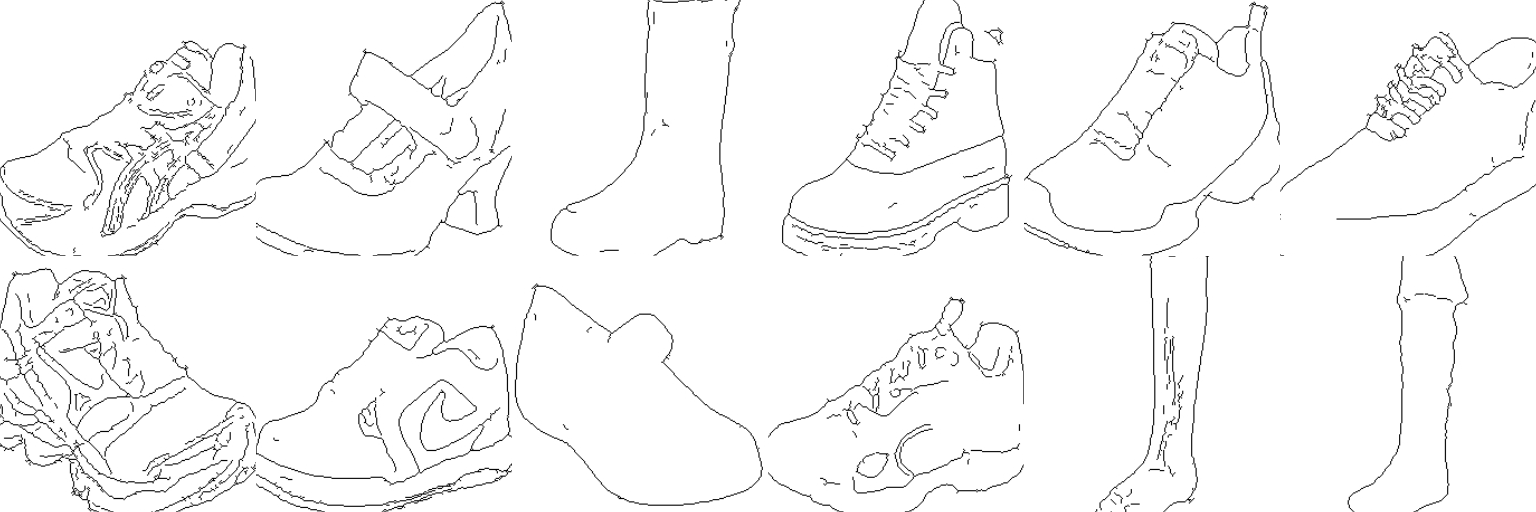

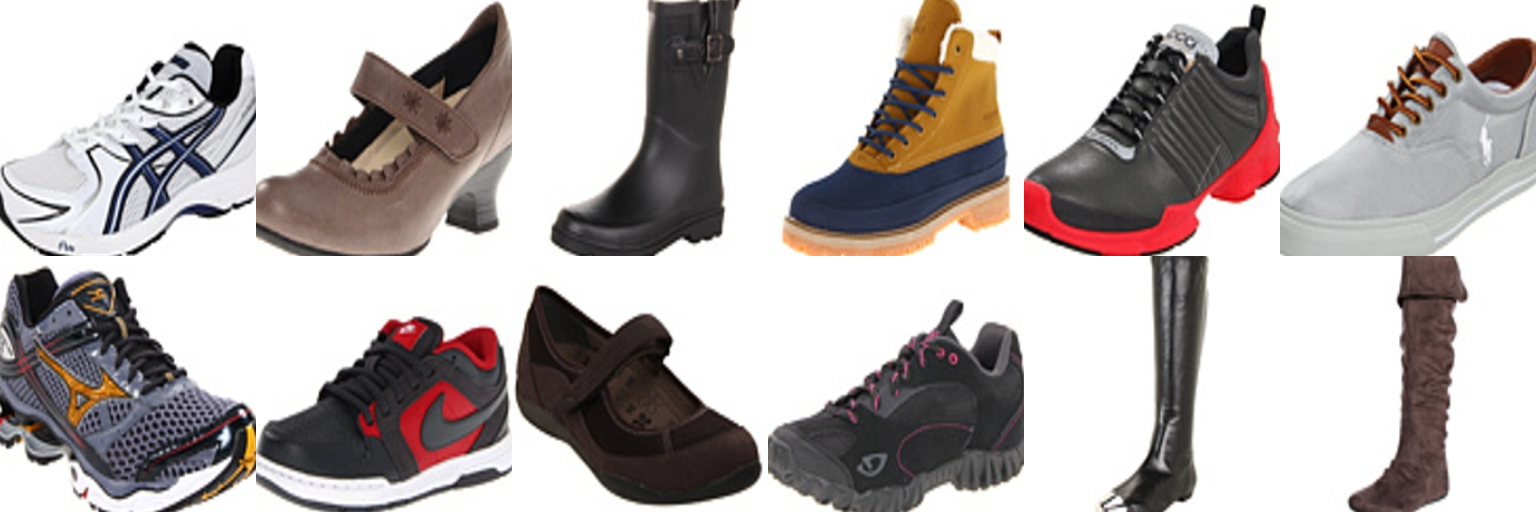

In [14]:
train_batch = minibatch(trainAB, 12, direction=direction)
_, trainA, trainB = next(train_batch)
showX(trainA, 2)
showX(trainB, 2)
del train_batch, trainA, trainB

In [ ]:
def netG_gen(A):
    return np.concatenate([netG_generate(A[i:i+1]) for i in range(A.shape[0])], axis=0)

[0/50][500] Loss_D: 0.394792 Loss_G: 1.992612 loss_L1: 0.327777 37.58769702911377


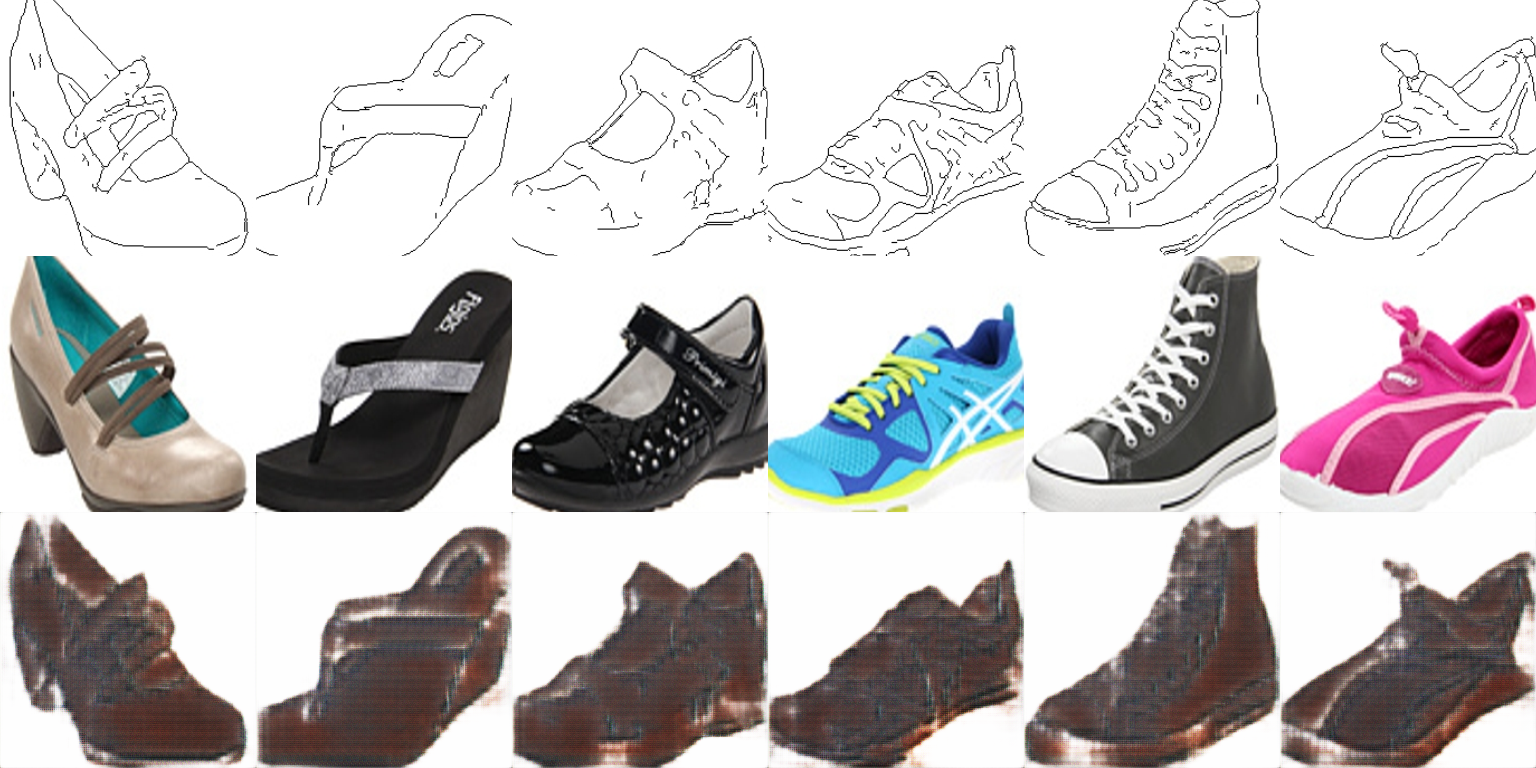

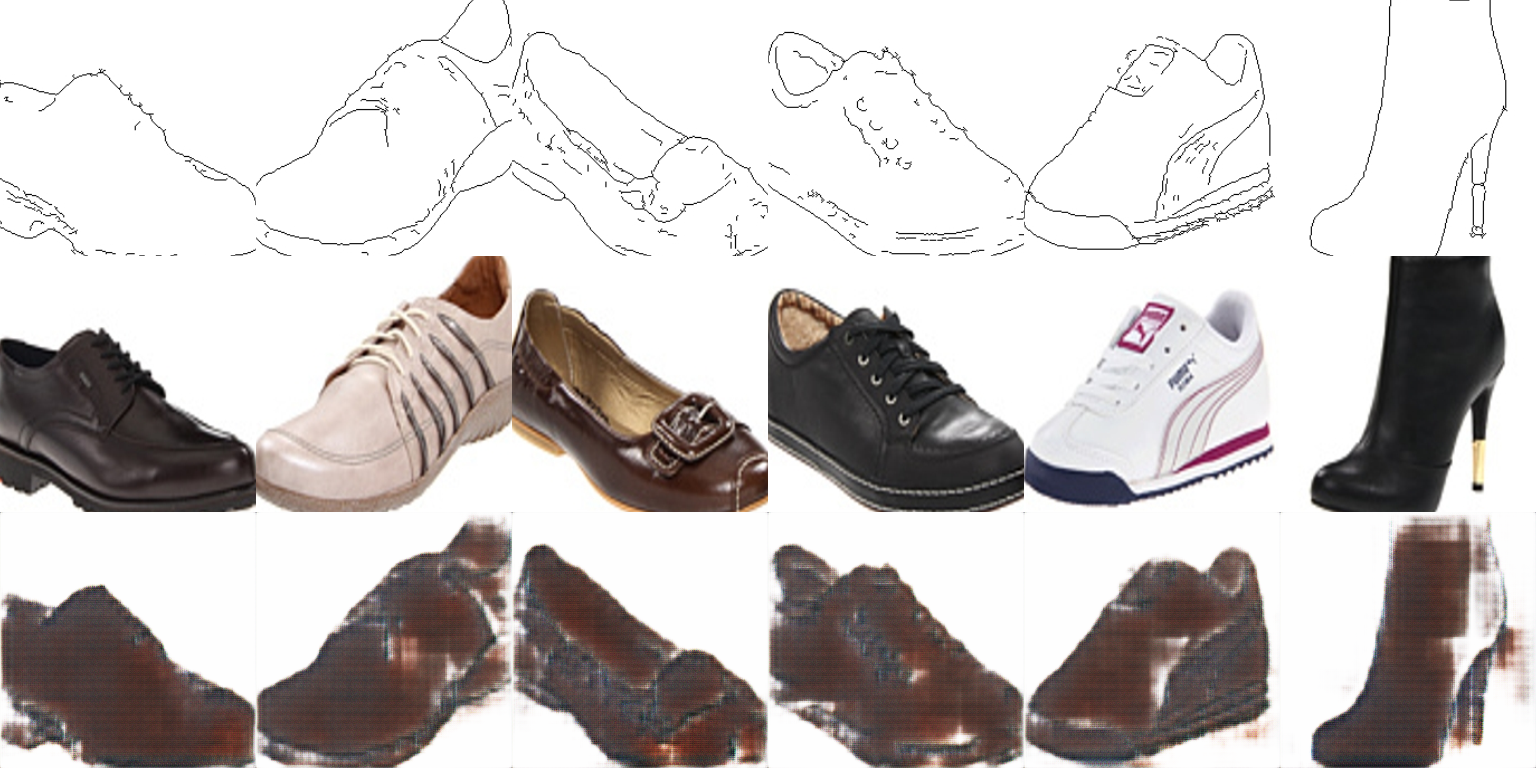

[0/50][1000] Loss_D: 0.440574 Loss_G: 1.746097 loss_L1: 0.243235 75.32544255256653


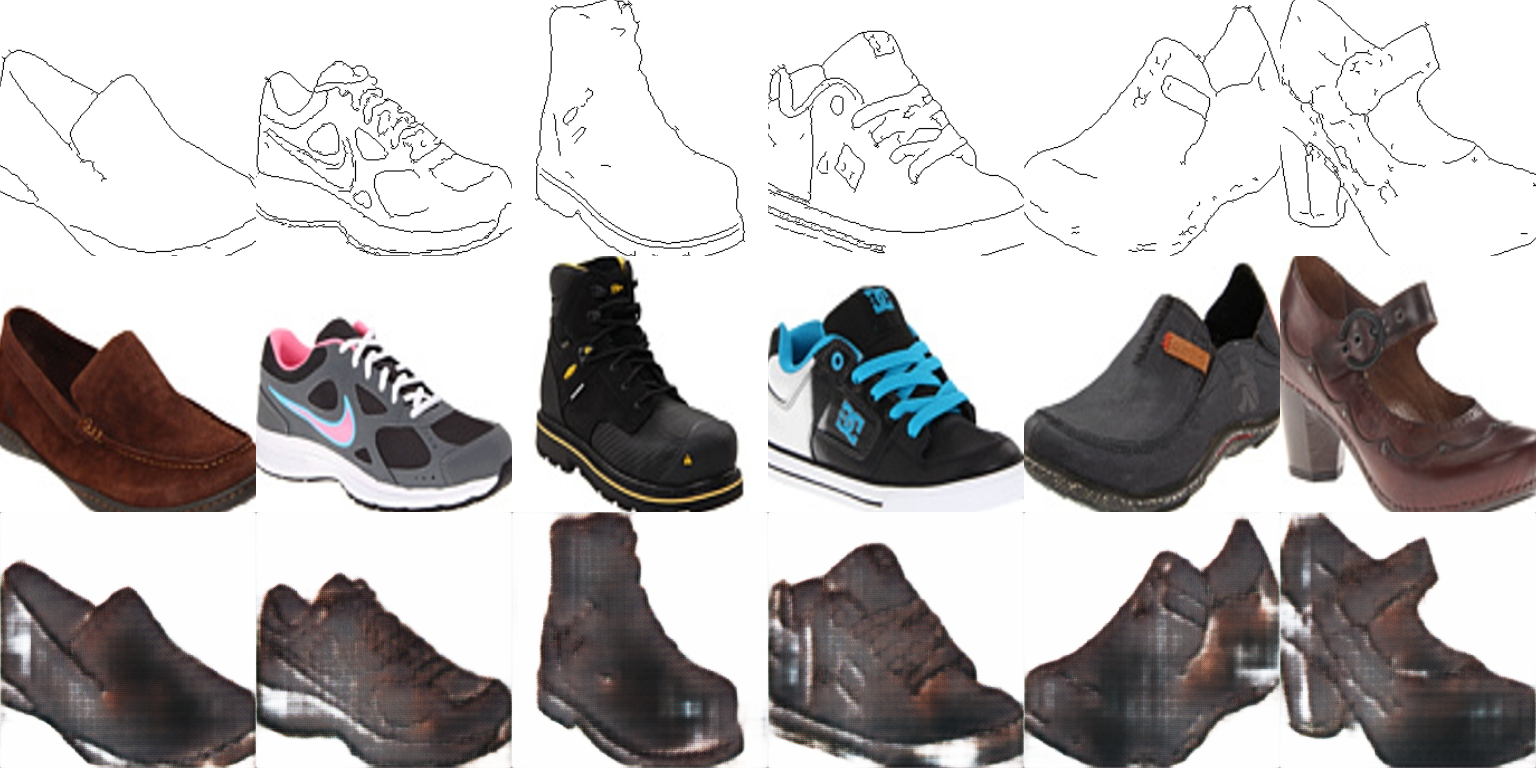

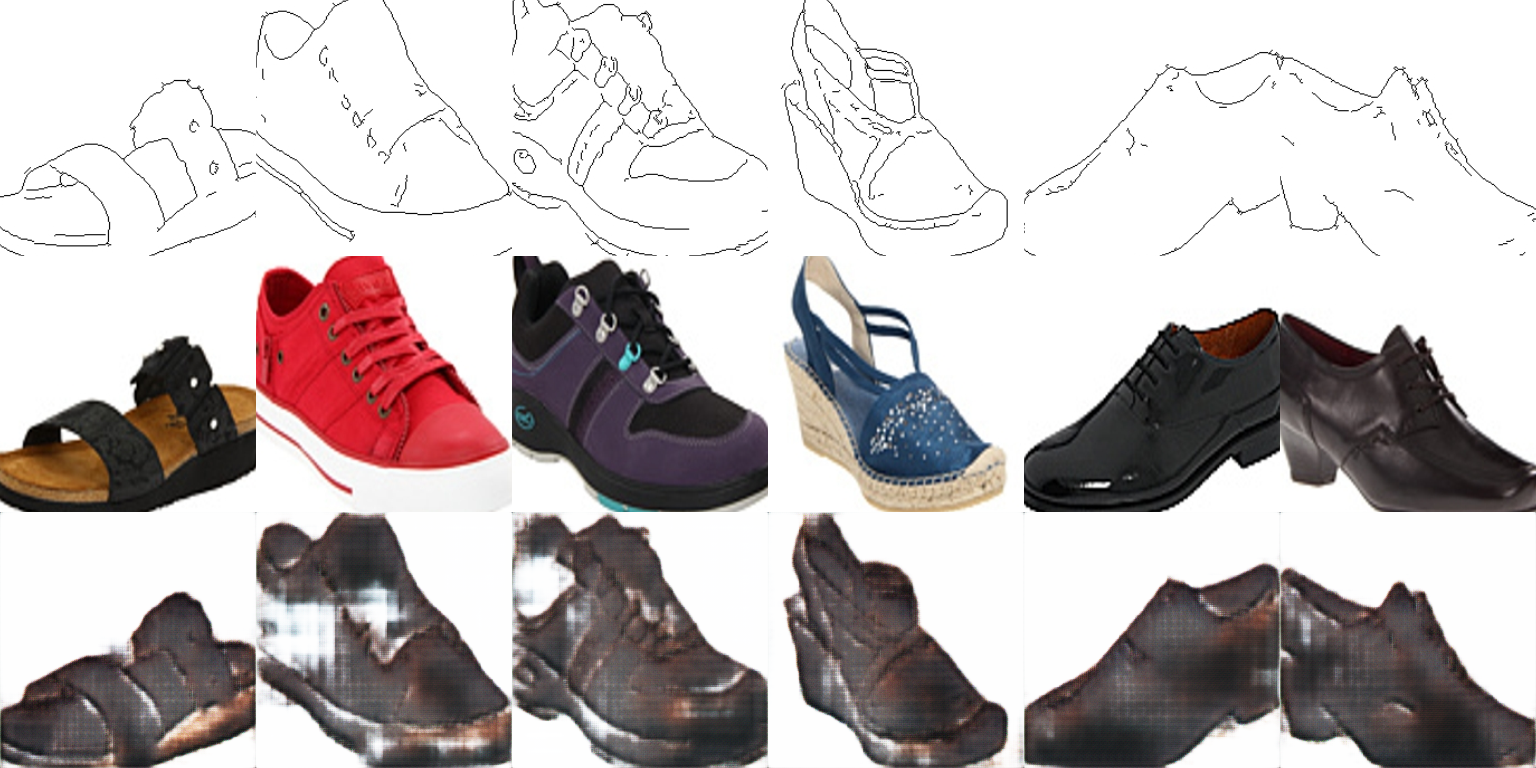

In [ ]:
import time
from IPython.display import clear_output
t0 = time.time()
niter = 50
gen_iterations = 0
errL1 = epoch = errG = 0
errL1_sum = errG_sum = errD_sum = 0

display_iters = 500
val_batch = minibatch(valAB, 6, direction)
train_batch = minibatch(trainAB, batchSize, direction)

while epoch < niter: 
    epoch, trainA, trainB = next(train_batch)        
    errD,  = netD_train(trainA, trainB)
    errD_sum +=errD

    # epoch, trainA, trainB = next(train_batch)
    errG, errL1 = netG_train(trainA, trainB)
    errG_sum += errG
    errL1_sum += errL1
    gen_iterations+=1
    if gen_iterations%display_iters==0:
        if gen_iterations%(5*display_iters)==0:
            clear_output()
        print('[%d/%d][%d] Loss_D: %f Loss_G: %f loss_L1: %f'
        % (epoch, niter, gen_iterations, errD_sum/display_iters, errG_sum/display_iters, errL1_sum/display_iters), time.time()-t0)
        _, valA, valB = train_batch.send(6) 
        fakeB = netG_gen(valA)
        showX(np.concatenate([valA, valB, fakeB], axis=0), 3)
        errL1_sum = errG_sum = errD_sum = 0
        _, valA, valB = next(val_batch)
        fakeB = netG_gen(valA)
        showX(np.concatenate([valA, valB, fakeB], axis=0), 3)
        